{'data_quality': {'total_records': 8245, 'missing_values': np.int64(0), 'feature_count': 31}, 'price_distribution': {'mean_price': np.float64(1394375.1750151608), 'median_price': np.float64(1390943.0), 'price_range': (np.int64(300810), np.int64(2499798))}, 'key_correlations': {'ID': {'correlation': np.float64(-0.00888642639483882), 'p_value': np.float64(0.41978245663037966)}, 'Prod. year': {'correlation': np.float64(-0.007749341062611439), 'p_value': np.float64(0.4817071985553206)}, 'Cylinders': {'correlation': np.float64(0.010226456633682072), 'p_value': np.float64(0.35316588552114636)}, 'Airbags': {'correlation': np.float64(-0.0032188762898256434), 'p_value': np.float64(0.7701055842119446)}}, 'feature_importance': {'selected_features': ['Levy_encoded', 'Manufacturer_encoded', 'Leather interior_encoded', 'Drive wheels_encoded', 'Color_encoded'], 'feature_scores': {'ID': np.float64(0.6509893637681234), 'Prod. year': np.float64(0.4950407292831596), 'Cylinders': np.float64(0.862146526799

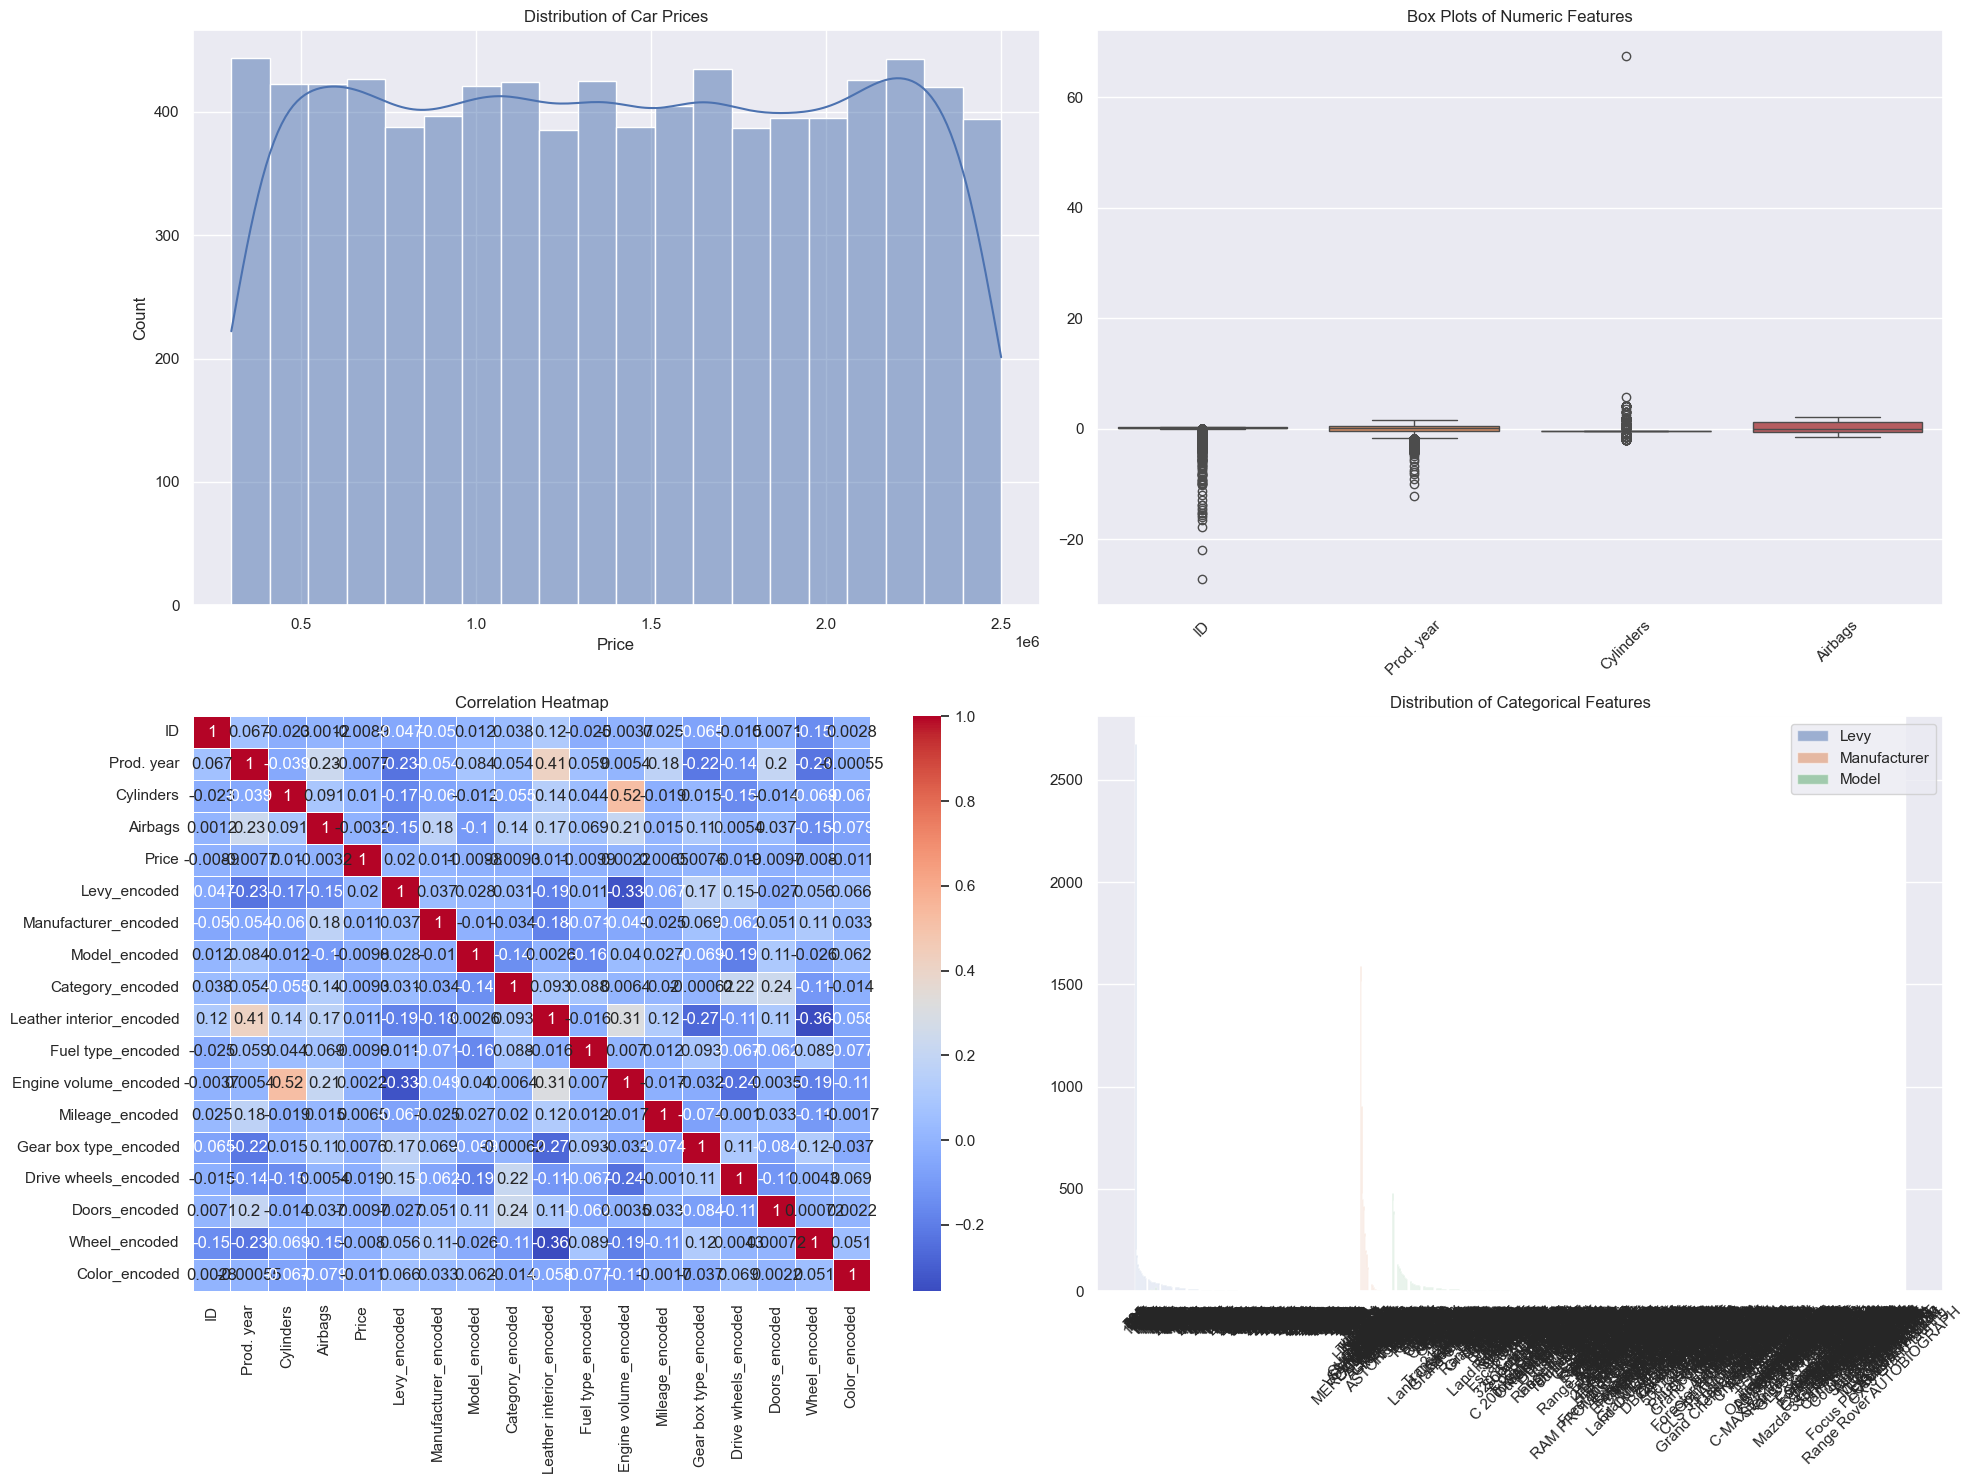

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class CarPriceAnalysis:
    def __init__(self, data):
        """Initialize with a DataFrame containing car data"""
        self.data = data
        self.numeric_features = []
        self.categorical_features = []
        
    def handle_missing_data(self):
        """Handle missing values in the dataset"""
        # Replace '-' with NaN
        self.data.replace('-', np.nan, inplace=True)
        
        # Identify numeric and categorical features
        self.numeric_features = self.data.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = self.data.select_dtypes(include=['object']).columns.tolist()
        
        # Handle missing values in numeric features
        for feature in self.numeric_features:
            if self.data[feature].isnull().any():
                self.data[feature] = self.data[feature].fillna(self.data[feature].mean())
        
        # Handle missing values in categorical features
        for feature in self.categorical_features:
            if self.data[feature].isnull().any():
                self.data[feature] = self.data[feature].fillna(self.data[feature].mode()[0])
        
        return self.data

    
    def data_transformation(self):
        """Transform and encode the data"""
        # Identify numeric and categorical features
        self.numeric_features = self.data.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.numeric_features.remove('Price')  # Remove Price from numeric features
        self.categorical_features = self.data.select_dtypes(include=['object']).columns.tolist()

        
        # Label encode categorical variables
        le = LabelEncoder()
        for col in self.categorical_features:
            self.data[col + '_encoded'] = le.fit_transform(self.data[col])
            
        # Scale numeric features
        scaler = StandardScaler()
        self.data[self.numeric_features] = scaler.fit_transform(self.data[self.numeric_features])
        
        return self.data
    
    def descriptive_statistics(self):
        """Generate descriptive statistics"""
        stats_dict = {
            'numeric_summary': self.data[self.numeric_features].describe(),
            'categorical_summary': {col: self.data[col].value_counts() 
                                  for col in self.categorical_features}
        }
        return stats_dict
    
    def visualize_data(self):
        """Create various visualizations"""
        sns.set()
        fig = plt.figure(figsize=(20, 15))
        
        # Distribution of target variable (Price)
        plt.subplot(2, 2, 1)
        sns.histplot(self.data['Price'], kde=True)
        plt.title('Distribution of Car Prices')


        
        # Box plots of numeric features
        plt.subplot(2, 2, 2)
        sns.boxplot(data=self.data[self.numeric_features])
        plt.xticks(rotation=45)
        plt.title('Box Plots of Numeric Features')
        
        # Correlation heatmap
        plt.subplot(2, 2, 3)
        correlation_matrix = self.data.select_dtypes(include=['float64', 'int64']).corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Heatmap')
        
        # Categorical feature distribution
        plt.subplot(2, 2, 4)
        for i, col in enumerate(self.categorical_features[:3]):  # Show top 3 categorical features
            plt.bar(self.data[col].value_counts().index, 
                   self.data[col].value_counts().values,
                   alpha=0.5,
                   label=col)
        plt.legend()
        plt.xticks(rotation=45)
        plt.title('Distribution of Categorical Features')
        
        plt.tight_layout()
        return fig
    
    def correlation_analysis(self):
        """Perform correlation analysis"""
        # Calculate correlations with Price
        numeric_correlations = self.data[self.numeric_features].corrwith(self.data['Price'])
        
        # Calculate correlation significance
        correlation_significance = {}
        for feature in self.numeric_features:
            correlation, p_value = stats.pearsonr(self.data[feature], self.data['Price'])
            correlation_significance[feature] = {
                'correlation': correlation,
                'p_value': p_value
            }
        
        return correlation_significance

    
    def feature_selection(self, k=5):
        """Select top k features based on F-regression"""
        X = self.data.drop('Price', axis=1).select_dtypes(include=['int64', 'float64'])
        y = self.data['Price']
    
        # Select K best features
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
    
        # Get selected feature names
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = dict(zip(X.columns, selector.scores_))
    
        return {
            'selected_features': selected_features,
            'feature_scores': feature_scores
        }
 
    def hypothesis_testing(self):
        """Perform hypothesis testing"""
        hypothesis_results = {}
    
        # Test for normality of Price
        _, price_normality_pvalue = stats.normaltest(self.data['Price'])
        hypothesis_results['price_normality'] = {
            'test': 'Normality Test',
            'p_value': price_normality_pvalue,
            'is_normal': price_normality_pvalue > 0.05
        }
    
        # ANOVA test for categorical variables
        for feature in self.categorical_features:
            anova_f_value, anova_p_value = stats.f_oneway(*[self.data[self.data[feature] == category]['Price'] for category in self.data[feature].unique()])
            hypothesis_results[f'{feature}_anova'] = {
                'test': 'ANOVA Test',
                'f_value': anova_f_value,
                'p_value': anova_p_value,
                'reject_null_hypothesis': anova_p_value < 0.05
            }
    
        return hypothesis_results
    
    def interpret_findings(self):
        """Generate interpretation of the analysis"""
        interpretations = {
            'data_quality': {
                'total_records': len(self.data),
                'missing_values': self.data.isnull().sum().sum(),
                'feature_count': len(self.data.columns)
            },
            'price_distribution': {
                'mean_price': self.data['Price'].mean(),
                'median_price': self.data['Price'].median(),
                'price_range': (self.data['Price'].min(), self.data['Price'].max())
            },
            'key_correlations': self.correlation_analysis(),
            'feature_importance': self.feature_selection(),
            'hypothesis_results': self.hypothesis_testing()
        }
        
        return interpretations

# Example usage
def run_analysis(data_path):
    """Run the complete analysis pipeline"""
    # Load data
    data = pd.read_csv(data_path)
    
    # Initialize analyzer
    analyzer = CarPriceAnalysis(data)
    
    # Run analysis pipeline
    analyzer.handle_missing_data()
    analyzer.data_transformation()
    stats = analyzer.descriptive_statistics()
    visualizations = analyzer.visualize_data()
    correlations = analyzer.correlation_analysis()
    selected_features = analyzer.feature_selection()
    hypothesis_results = analyzer.hypothesis_testing()
    interpretations = analyzer.interpret_findings()
    
    return {
        'analyzer': analyzer,
        'statistics': stats,
        'visualizations': visualizations,
        'correlations': correlations,
        'selected_features': selected_features,
        'hypothesis_results': hypothesis_results,
        'interpretations': interpretations
    }
# Run the analysis pipeline
results = run_analysis('car_data.csv')

# Print the results
print(results['interpretations'])
